# Importing Packages

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import joblib
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go
import plotly.express as px
from tensorflow.keras.metrics import AUC, Precision, Recall, F1Score

# Importing the Data

The data is imported from a github repo but is pulled from [nflfastR](https://www.nflfastr.com/). It contains play by play data. For this project, we only pull data between the years of 2000 to 2024 inclusive. 

In [282]:
# Load play-by-play data from 2015 5o 
years = range(2000, 2025)  # 2015 to 2024
pbp_data = pd.concat(
    [
        pd.read_csv(
            f'https://github.com/nflverse/nflverse-data/releases/download/pbp/play_by_play_{year}.csv.gz',
            compression='gzip', low_memory=False
        ) for year in years
    ],
    ignore_index=True
)

In [283]:
list(pbp_data.columns)

['play_id',
 'game_id',
 'old_game_id',
 'home_team',
 'away_team',
 'season_type',
 'week',
 'posteam',
 'posteam_type',
 'defteam',
 'side_of_field',
 'yardline_100',
 'game_date',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'game_half',
 'quarter_end',
 'drive',
 'sp',
 'qtr',
 'down',
 'goal_to_go',
 'time',
 'yrdln',
 'ydstogo',
 'ydsnet',
 'desc',
 'play_type',
 'yards_gained',
 'shotgun',
 'no_huddle',
 'qb_dropback',
 'qb_kneel',
 'qb_spike',
 'qb_scramble',
 'pass_length',
 'pass_location',
 'air_yards',
 'yards_after_catch',
 'run_location',
 'run_gap',
 'field_goal_result',
 'kick_distance',
 'extra_point_result',
 'two_point_conv_result',
 'home_timeouts_remaining',
 'away_timeouts_remaining',
 'timeout',
 'timeout_team',
 'td_team',
 'td_player_name',
 'td_player_id',
 'posteam_timeouts_remaining',
 'defteam_timeouts_remaining',
 'total_home_score',
 'total_away_score',
 'posteam_score',
 'defteam_score',
 'score_differential',
 'po

# Data Manipulation and Feature Engineering

In [284]:
def get_drive_points(group):
    # If any play has a touchdown, label as 6
    if group['touchdown'].any():
        return 6
    # If a field goal was made 
    elif (group['field_goal_result'] == 'made').any():
        return 3
    else:
        return 0

In [285]:
pbp_data['month'] = pd.to_datetime(pbp_data['game_date']).dt.month

/var/folders/34/g4lmjsg53yn3m175jbcsg1gm0000gn/T/ipykernel_75752/2350793208.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Aggreating the dataset so it is on the drive-level, not play level. This new dataset is now called drive_df.

In [286]:
drive_df = pbp_data.groupby(['game_id', 'drive']).apply(lambda group: pd.Series({
    'drive_points': get_drive_points(group),
    'total_yards': group['yards_gained'].sum(),
    'num_plays': group.shape[0],
    'starting_yardline': group.iloc[0]['yardline_100'],
    'drive_time_of_possession': group['drive_time_of_possession'].max(),
    'first_downs': group['drive_first_downs'].max(), 
    'score_differential': group.iloc[-1]['score_differential'],
    'weather': group.iloc[0]['weather'],
    'team': group.iloc[0]['posteam'],
    'season': group.iloc[0]['season'],
    'timeouts': group['posteam_timeouts_remaining'].min(),
    'game_month': group.iloc[0]['month']
})).reset_index()

In [287]:
drive_df.head()

,game_id,drive,drive_points,total_yards,num_plays,starting_yardline,drive_time_of_possession,first_downs,score_differential,weather,team,season,timeouts,game_month
0,2000_01_ARI_NYG,1.0,0,2.0,6,30.0,1:20,0.0,0.0,NaN,ARI,2000,3.0,9
1,2000_01_ARI_NYG,2.0,0,39.0,9,78.0,3:41,3.0,0.0,NaN,NYG,2000,3.0,9
2,2000_01_ARI_NYG,3.0,0,29.0,10,94.0,4:49,2.0,0.0,NaN,ARI,2000,3.0,9
3,2000_01_ARI_NYG,4.0,6,71.0,12,66.0,5:10,4.0,6.0,NaN,NYG,2000,3.0,9
4,2000_01_ARI_NYG,5.0,0,6.0,8,98.0,2:05,0.0,-7.0,NaN,ARI,2000,3.0,9


Converting the drive_time_of_possession to seconds.

In [288]:
def time_to_seconds(time_str):
    try:
        minutes, seconds = time_str.split(':')
        return int(minutes) * 60 + int(seconds)
    except Exception as e:
        return np.nan

drive_df['drive_time_of_possession_seconds'] = drive_df['drive_time_of_possession'].apply(time_to_seconds)

In [289]:
drive_df.head()

,game_id,drive,drive_points,total_yards,num_plays,starting_yardline,drive_time_of_possession,first_downs,score_differential,weather,team,season,timeouts,game_month,drive_time_of_possession_seconds
0,2000_01_ARI_NYG,1.0,0,2.0,6,30.0,1:20,0.0,0.0,NaN,ARI,2000,3.0,9,80
1,2000_01_ARI_NYG,2.0,0,39.0,9,78.0,3:41,3.0,0.0,NaN,NYG,2000,3.0,9,221
2,2000_01_ARI_NYG,3.0,0,29.0,10,94.0,4:49,2.0,0.0,NaN,ARI,2000,3.0,9,289
3,2000_01_ARI_NYG,4.0,6,71.0,12,66.0,5:10,4.0,6.0,NaN,NYG,2000,3.0,9,310
4,2000_01_ARI_NYG,5.0,0,6.0,8,98.0,2:05,0.0,-7.0,NaN,ARI,2000,3.0,9,125


Assigning the predictive and target variables in X and y respectively.

In [290]:
features = ['num_plays', 'starting_yardline',
            'drive_time_of_possession_seconds', 'first_downs', 'score_differential', 'team_encoded', 'season', 'timeouts']
encoder = LabelEncoder()
drive_df['team_encoded'] = encoder.fit_transform(drive_df['team'])
X = drive_df[features]
y = drive_df['drive_points']

Mapping drive outcome to levels for the neural network to process.

In [291]:
# Map the drive outcome points to categorical labels
# 0 -> 0, 3 -> 1, 6 -> 2
mapping = {0: 0, 3: 1, 6: 2}
y = y.map(mapping)

In [292]:
y_cat = to_categorical(y)

# Prepping the Data for Modelling

Splitting the data into train and test

In [293]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=123)

In [294]:
print("NaNs in X_train:", np.isnan(X_train).sum())
print("NaNs in y_train:", np.isnan(y_train).sum())

NaNs in X_train: num_plays                              0
starting_yardline                     93
drive_time_of_possession_seconds       0
first_downs                            0
score_differential                  4823
team_encoded                           0
season                                 0
timeouts                               1
dtype: int64
NaNs in y_train: 0


Replacing NaNs in the score_differential column with zeros.

In [295]:
X_train['score_differential'].fillna(0, inplace=True)

Scaling the predictive matricies.

In [296]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Dropping rows with NaN values.

In [297]:
nan_mask = np.isnan(X_train).any(axis=1)
X_train = X_train[~nan_mask]
y_train = y_train[~nan_mask]

Splitting the train data into train and validation

In [298]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=123)

# Creating the Model

In [299]:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

In [300]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[
        'accuracy',
        AUC(name='auc'),
        Precision(name='precision'),
        Recall(name='recall'),
        F1Score(name='f1_score', average='macro')
    ]
)

checkpoint = ModelCheckpoint(
    "best_model.h5",
    save_best_only=True,
    monitor="val_auc",
    mode="max"
)

# Training the Model

In [301]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=64,
    verbose=1,
    callbacks=[checkpoint]
)

Epoch 1/25
1751/1751 [==============================] - 1s 421us/step - loss: 0.5281 - accuracy: 0.7949 - auc: 0.9261 - precision: 0.8348 - recall: 0.7449 - f1_score: 0.6457 - val_loss: 0.4707 - val_accuracy: 0.8167 - val_auc: 0.9406 - val_precision: 0.8466 - val_recall: 0.7750 - val_f1_score: 0.6981
Epoch 2/25
 446/1751 [======>.......................] - ETA: 0s - loss: 0.4950 - accuracy: 0.8066 - auc: 0.9345 - precision: 0.8390 - recall: 0.7653 - f1_score: 0.6692

/Users/vanisingh/anaconda3/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



1751/1751 [==============================] - 1s 370us/step - loss: 0.4860 - accuracy: 0.8084 - auc: 0.9368 - precision: 0.8415 - recall: 0.7689 - f1_score: 0.6726 - val_loss: 0.4629 - val_accuracy: 0.8186 - val_auc: 0.9423 - val_precision: 0.8445 - val_recall: 0.7839 - val_f1_score: 0.6982
Epoch 3/25
1751/1751 [==============================] - 1s 371us/step - loss: 0.4785 - accuracy: 0.8117 - auc: 0.9387 - precision: 0.8412 - recall: 0.7753 - f1_score: 0.6800 - val_loss: 0.4548 - val_accuracy: 0.8188 - val_auc: 0.9444 - val_precision: 0.8495 - val_recall: 0.7833 - val_f1_score: 0.6978
Epoch 4/25
1751/1751 [==============================] - 1s 372us/step - loss: 0.4700 - accuracy: 0.8138 - auc: 0.9408 - precision: 0.8444 - recall: 0.7785 - f1_score: 0.6892 - val_loss: 0.4482 - val_accuracy: 0.8225 - val_auc: 0.9460 - val_precision: 0.8524 - val_recall: 0.7856 - val_f1_score: 0.7063
Epoch 5/25
1751/1751 [==============================] - 1s 372us/step - loss: 0.4646 - accuracy: 0.8155 -

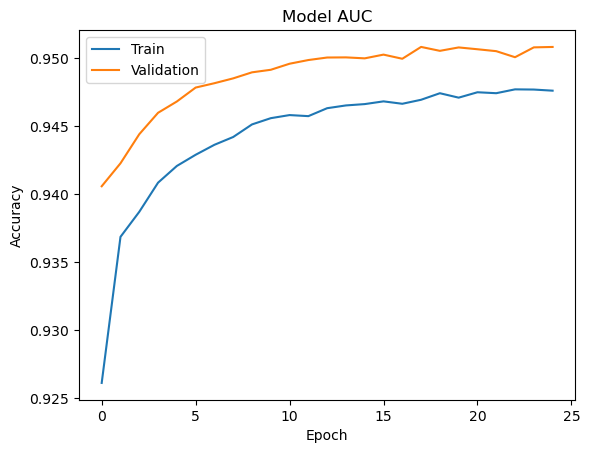

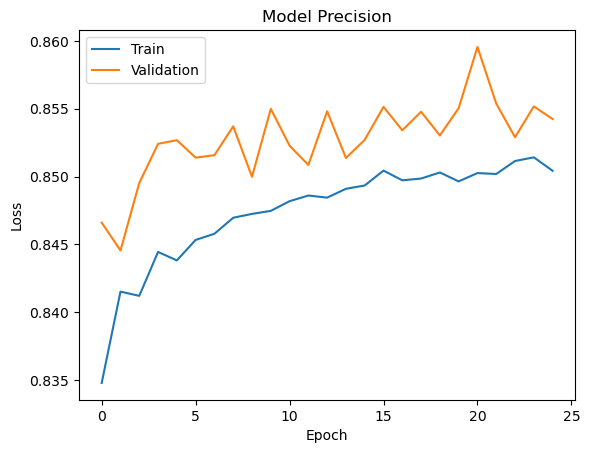

In [302]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluating the Model on Test Data

In [303]:
best_model = load_model("best_model.h5")
# Get all metrics including loss, accuracy, AUC, and precision
test_metrics = best_model.evaluate(X_test, y_test, verbose=0)

# Get predictions for ROC AUC calculation
y_pred = best_model.predict(X_test)

print(f"Test Loss: {test_metrics[0]:.4f}")
print(f"Test AUC: {test_metrics[2]:.4f}") 
print(f"Test Precision: {test_metrics[3]:.4f}")

974/974 [==============================] - 0s 169us/step
Test Loss: nan
Test AUC: 0.9155
Test Precision: 0.8502


# Saving the Encoding the Scaling

In [304]:
joblib.dump(scaler, "scaler.pkl")
joblib.dump(encoder, 'team_encoder.pkl')

['team_encoder.pkl']

# Generating a Graph for Predicted vs Actual Average Points per Drive for Each Team Throughout the Seasons

In [305]:
drive_df.to_csv('drive_data.csv')

In [306]:
actual_points = drive_df.groupby(['team', 'season'])['drive_points'].mean().reset_index()

X_pred = drive_df[['num_plays', 'starting_yardline', 'drive_time_of_possession_seconds',
                   'first_downs', 'score_differential', 'team_encoded', 'season', 'timeouts']]
scaler = StandardScaler()
X_pred = scaler.fit_transform(X_pred)
predicted_probs = best_model.predict(X_pred)
predicted_points = np.argmax(predicted_probs, axis=1) * 3

4866/4866 [==============================] - 1s 169us/step


In [307]:
drive_df['predicted_drive_points'] = predicted_points

In [308]:
predicted_points_avg = drive_df.groupby(['team', 'season'])['predicted_drive_points'].mean().reset_index()
comparison_df = actual_points.merge(predicted_points_avg, on=['team', 'season'], suffixes=('_actual', '_predicted'))

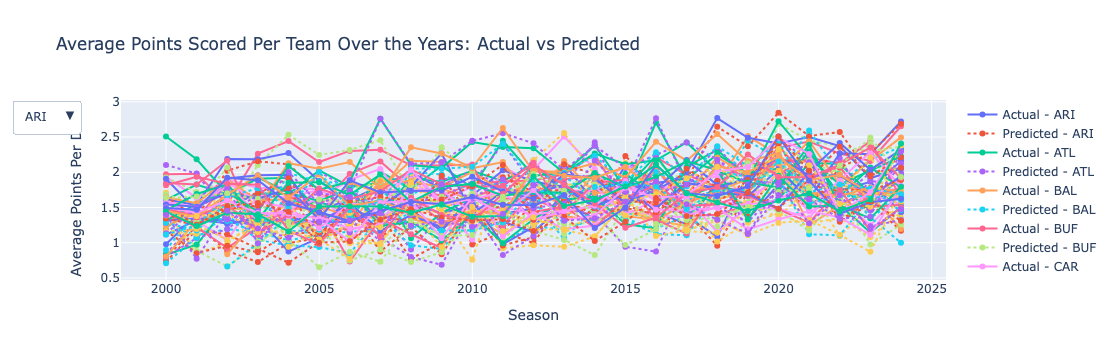

In [309]:
teams = comparison_df['team'].unique()
fig = go.Figure()

for team in teams:
    team_data = comparison_df[comparison_df['team'] == team]
    fig.add_trace(go.Scatter(x=team_data['season'], y=team_data['drive_points'],
                              mode='lines+markers', name=f'Actual - {team}'))
    fig.add_trace(go.Scatter(x=team_data['season'], y=team_data['predicted_drive_points'],
                              mode='lines+markers', name=f'Predicted - {team}', line=dict(dash='dot')))

fig.update_layout(
    title='Average Points Scored Per Team Over the Years: Actual vs Predicted',
    xaxis_title='Season',
    yaxis_title='Average Points Per Drive',
    updatemenus=[
        {
            'buttons': [
                {
                    'label': team,
                    'method': 'update',
                    'args': [
                        {'visible': [str(team) in trace.name for trace in fig.data]},
                        {'title': f'Average Points for {team}'}
                    ]
                }
                for team in teams
            ],
            'direction': 'down',
            'showactive': True,
        }
    ]
)

fig.show()